In [46]:
# Suppress Warning messages
import warnings
warnings.simplefilter(action='ignore')

In [47]:
import pandas as pd
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [48]:
PROBLEM_NAME = 'ContinuousPeaks'
# EXT = '_t_pct_0.1_n_100'
EXT = '_t_pct_0.4_n_100'

ALGORITHMS = [
    'RHC', 
    'SA', 
    'GA', 
    'MIMIC',
]

In [49]:
out_dir = f'learning_curves{EXT}'
os.makedirs(out_dir, exist_ok=True)

In [50]:
df_dict = {}
for algorithm in ALGORITHMS:
    all_df = pd.read_csv(f'metrics{EXT}/{PROBLEM_NAME}_100_{algorithm}/learning_curve.csv')
    # print(f"before: {len(all_df)}")
    best_run_num = all_df[all_df['Fitness'] == all_df['Fitness'].max()].iloc[0]['group_number']
    df = all_df[all_df['group_number'] == best_run_num]
    # print(f"{len(df)}")
    df_dict[algorithm] = df

In [51]:
if 'RHC' in df_dict:
    df = df_dict['RHC']
    for run_num in tqdm(df['run_number'].unique()):
        add_time = 0
        s_df = df[df['run_number'] == run_num]
        for restart in sorted(s_df['current_restart'].unique()):
            mask = np.logical_and(df['run_number'] == run_num, df['current_restart'] == restart)
            df.loc[mask, 'Time'] = df.loc[mask, 'Time'] + add_time
            add_time = df[mask]['Time'].max()

100%|██████████| 3/3 [00:00<00:00,  6.63it/s]


In [52]:
if 'RHC' in df_dict:
    df = df_dict['RHC']
    for run_num in tqdm(df['run_number'].unique()):
        best_fitness = None
        s_df = df[df['run_number'] == run_num]
        for i, row in s_df.iterrows():
            if best_fitness is None or row['Fitness'] > best_fitness:
                best_fitness = row['Fitness']
            df.loc[i, 'Fitness'] = best_fitness

100%|██████████| 3/3 [00:23<00:00,  7.69s/it]


In [53]:
data_dict = {}

max_time = all_df['Time'].max()
print(len(ALGORITHMS))
for alg, df in df_dict.items():
    print(f"Algorithm: {alg}")
    print(f"Iterations: {df['Iteration'].max()}")
    run_num = df['run_number'].unique()[0]
    run_df = df[df['run_number'] == run_num]
    print(len(run_df))
    for i, row in tqdm(run_df.iterrows()):
        s_df = df[df['Iteration'] == row['Iteration']]
        run_df.loc[i, 'fitness_mean'] = s_df['Fitness'].mean()
        run_df.loc[i, 'fitness_std'] = s_df['Fitness'].std()
    run_df = run_df.sort_values('Time')
    run_df = run_df.iloc[1:]
    X = np.array(run_df['Time'])
    y = np.array(run_df['fitness_mean'])
    y_error = np.array(run_df['fitness_std'])

    data_dict[alg] = (X, y, y_error)

4
Algorithm: RHC
Iterations: 957
23722


23722it [00:27, 861.56it/s]


Algorithm: SA
Iterations: 5552
5071


5071it [00:05, 905.38it/s]


Algorithm: GA
Iterations: 391
316


316it [00:00, 913.11it/s]


Algorithm: MIMIC
Iterations: 112
107


107it [00:00, 863.42it/s]


4


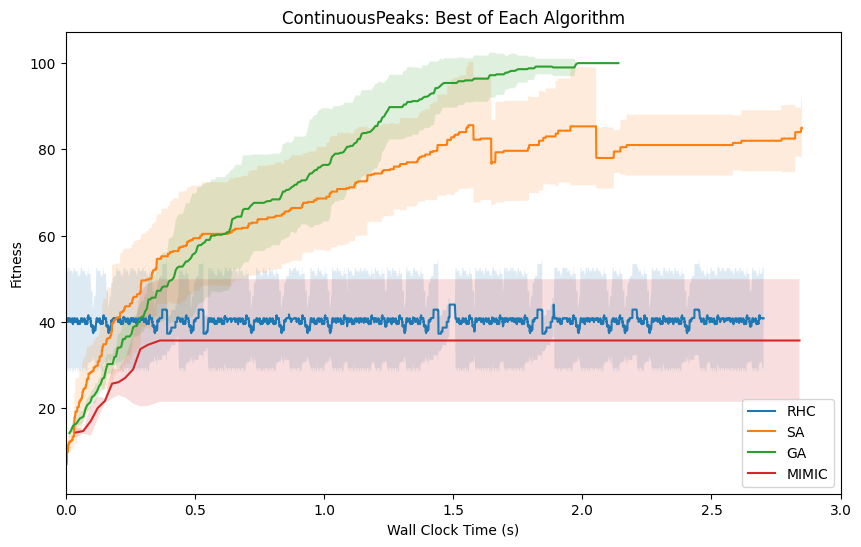

In [60]:
x_lim = 3
EXTEND = False
plt.figure(figsize=(10, 6))
max_time = all_df['Time'].max()
print(len(ALGORITHMS))
for alg, (X, y, y_error) in data_dict.items():
    if EXTEND:
        y = np.append(y, y[-1])
        X = np.append(X, max_time)
        y_error = np.append(y_error, y_error[-1])
    y_error = y_error
    X = X[X < (0.95 * x_lim)]
    y = y[:len(X)]
    y_error = y_error[:len(X)]
    plt.plot(X, y, label=alg)
    plt.fill_between(X, y-y_error, y+y_error, alpha=0.15)
# set x limit to 200
plt.xlim(0, 3)
# set xlabel to Wall Clock Time (s) 
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Fitness')
# set legend position to bottom right
plt.legend(loc='lower right')
plt.title(f'{PROBLEM_NAME}: Best of Each Algorithm')

save_path = os.path.join(out_dir, f"{PROBLEM_NAME}_all_algorithms.png") 
# plt.savefig(save_path)
plt.show()

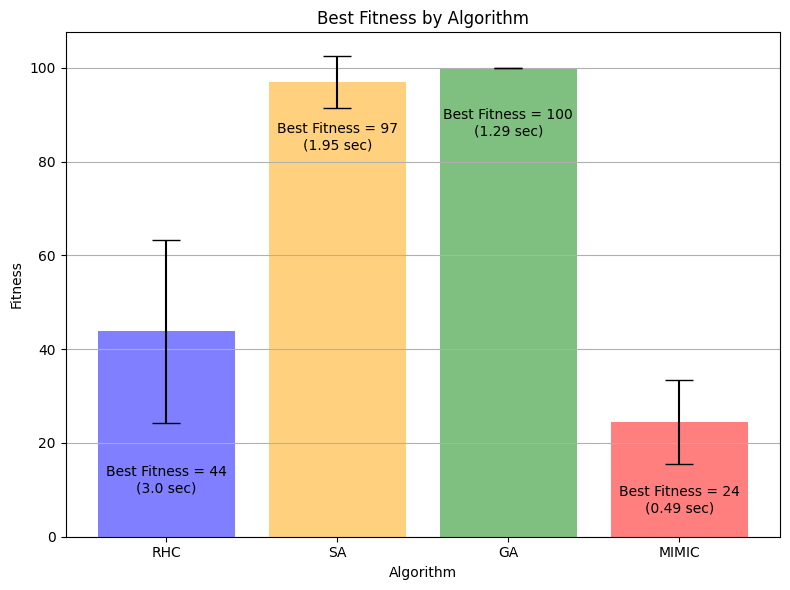

In [61]:
colors = ['b', 'orange', 'g', 'r']
fig, ax = plt.subplots(figsize=(8, 6))

x_pos = np.arange(len(ALGORITHMS))
means = []
stds = []
mean_times = []

for alg in ALGORITHMS:
    all_df = pd.read_csv(f'metrics{EXT}/{PROBLEM_NAME}_100_{alg}/learning_curve.csv')
    best_fitnesses = []
    times = []
    for run_i in all_df['run_number'].unique():
        run_df = all_df[all_df['run_number'] == run_i]
        run_df = run_df[run_df['Time'] < x_lim]
        best_fitnesses.append(run_df['Fitness'].max())
        max_df = run_df[run_df['Fitness'] == run_df['Fitness'].max()]
        t = max_df['Time'].values[0]
        if alg == 'RHC':
            t *= max_df['current_restart'].max()
        times.append(t)
    f = np.mean(best_fitnesses)
    means.append(f)
    s = f"Best Fitness = {round(f)}\n({round(np.mean(times), 2)} sec)"
    mean_times.append(s)
    stds.append(np.std(best_fitnesses))
    
ax.bar(x_pos, means, yerr=stds, align='center', alpha=0.5, ecolor='black', color=colors, capsize=10)
ax.set_ylabel('Fitness')
ax.set_xticks(x_pos)
ax.set_xticklabels(ALGORITHMS)
ax.set_xlabel('Algorithm')
ax.set_title('Best Fitness by Algorithm')
ax.yaxis.grid(True)

rects = ax.patches
for i, (rect, label) in enumerate(zip(rects, mean_times)):
    height = rect.get_height()
    if i == 0:
        ax.text(
            (rect.get_x() + rect.get_width() / 2) + 0, height - 35, label, ha="center", va="bottom"
        )
    elif i == 1 or i == 2:
        ax.text(
            (rect.get_x() + rect.get_width() / 2) + 0, height - 15, label, ha="center", va="bottom"
        )
    else:
        assert(i == 3)
        ax.text(
            (rect.get_x() + rect.get_width() / 2) + 0, height - 20, label, ha="center", va="bottom"
        )


# Save the figure and show
plt.tight_layout()
# plt.savefig('TODO.png')
plt.show()

In [ ]:
df = df_dict['SA']
print(df['Iteration'].min(), df['Iteration'].max())